In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
import math
import pandas as pd
import xgboost
import lightgbm
import catboost

from matplotlib.colors import ListedColormap
from scipy.stats import pearsonr
from itertools import combinations
from sklearn.base import BaseEstimator
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.ensemble import (RandomForestClassifier,
                              ExtraTreesClassifier,
                              VotingClassifier)
from sklearn.tree import (DecisionTreeRegressor,
                          DecisionTreeClassifier)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score, GridSearchCV

from scipy.special import comb
from scipy.stats import pearsonr

from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.preprocessing import (StandardScaler,
                                   OneHotEncoder)
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay


In [2]:
plt.rcParams["figure.figsize"] = 12, 9
sns.set_style("whitegrid")
warnings.filterwarnings("ignore")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)

### Задание 1. Bias-variance trade-off

**2 балла**

Продемонстрируйте bias-variance trade-off для `DecisionTreeRegressor` при изменении глубины дерева. Постройте регрессионную модель функции от одной независимой переменной, представленной в ячейке ниже, используя функцию `plot_regression_predictions` (можете ее как-то поменять, если захочется). Попробуйте разные значения глубины деревьев, при каком значении, на ваш взгляд, модель оптимальна, при каком variance становится слишком большим?

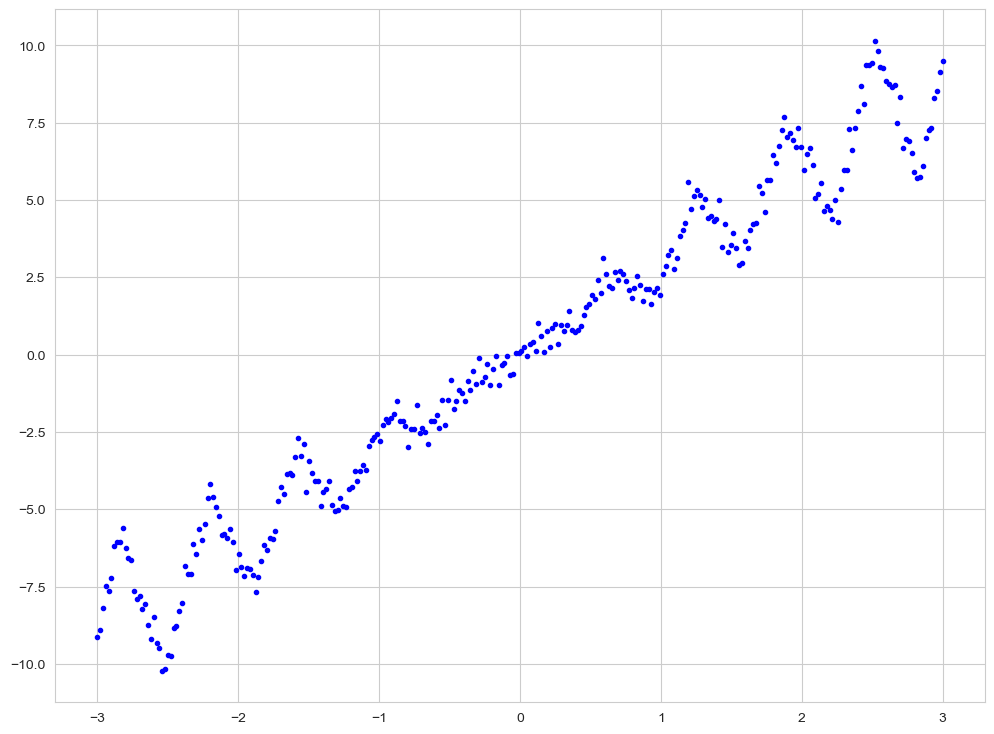

In [3]:
# Сгенерируем какую-нибудь необычную зависимость и научимся ее предсказывать
np.random.seed(42)
m = 300
X = np.linspace(-3, 3, m).reshape(-1, 1)
y = (3 + 2/np.pi * np.arcsin(np.cos(10 * X))) * X
y = y + np.random.randn(m, 1) / 3
plt.plot(X.reshape(-1), y.reshape(-1), "b.");

In [4]:
# Функция для отрисовки предсказаний деревьев решений в случае регрессии
def plot_regression_predictions(tree_reg, X, y, depth, ax, axes=[-3, 3, -10, 10], ylabel="$y$"):
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    y_pred = tree_reg.predict(x1)


    ax.set_xlabel("$x_1$", fontsize=18)
    ax.set_title(f'depth={depth}', fontsize=21)
    if ylabel:
        ax.set_ylabel(ylabel, fontsize=18, rotation=0)

    ax.plot(x1, y_pred, linewidth=2, label=r"$\hat{y}$")

Изобразите, как меняются предсказания дерева при увеличении максимальной глубины (можно взять что-то в диапазоне от 1 до 15):

In [5]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

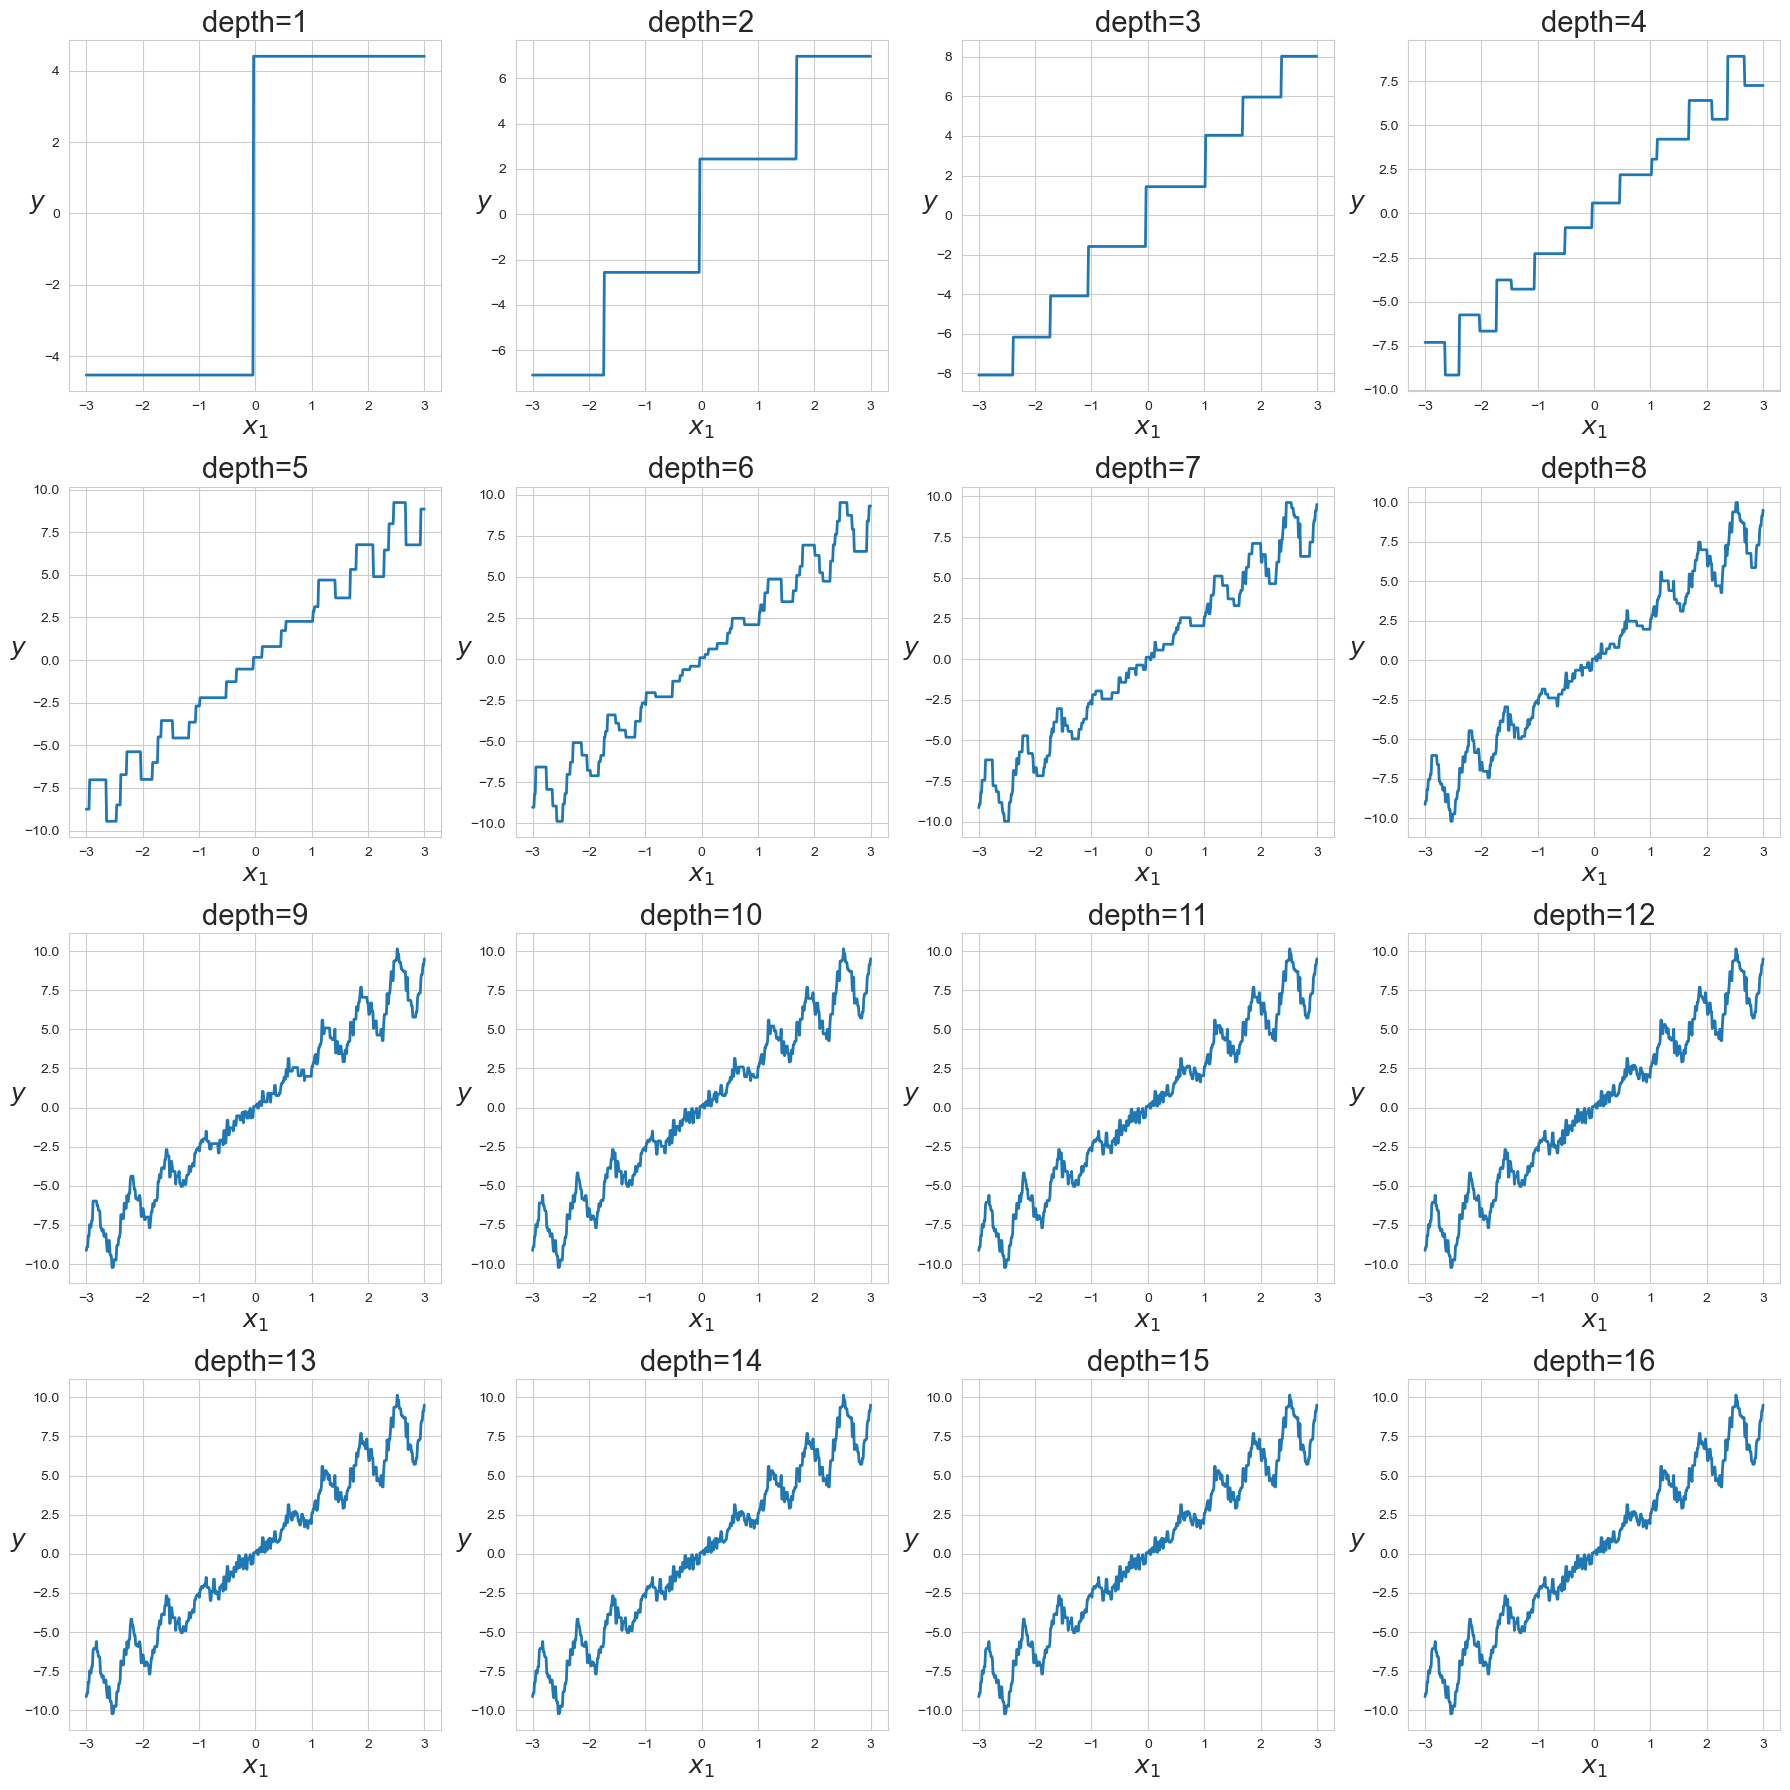

In [6]:
fig, axs = plt.subplots(4, 4, figsize=(18, 18))
axs = axs.flatten()

for depth, ax in enumerate(axs, 1):
    tree_regressor = DecisionTreeRegressor(max_depth=depth)
    tree_regressor.fit(X, y)
    plot_regression_predictions(tree_regressor, X, y, depth, ax)

plt.tight_layout()
plt.show()

**6,7 - оптимальны, дальше растет variance**

### Задание 2. Random forest

Теперь давайте немного подготовимся к тому, чтобы реализовать свой собственный случайный лес, а потом реализуем его.

#### Задание 2. 1. Простое ансамблирование

**1 балла**

Представим, что у нас есть 101 классификатор. Каждый может с вероятностью `p` (равной для всех моделей) правильно предсказать класс объекта. Будем делать предсказания по большинству голосов (majority vote). Постройте зависимость вероятности правильно классифицировать объект от значения `p`. Вам может быть полезная следующая формула:

$$ \large \mu = \sum_ {i = 51} ^ {101} C_{101} ^ ip ^ i (1-p) ^ {101-i} $$

In [7]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

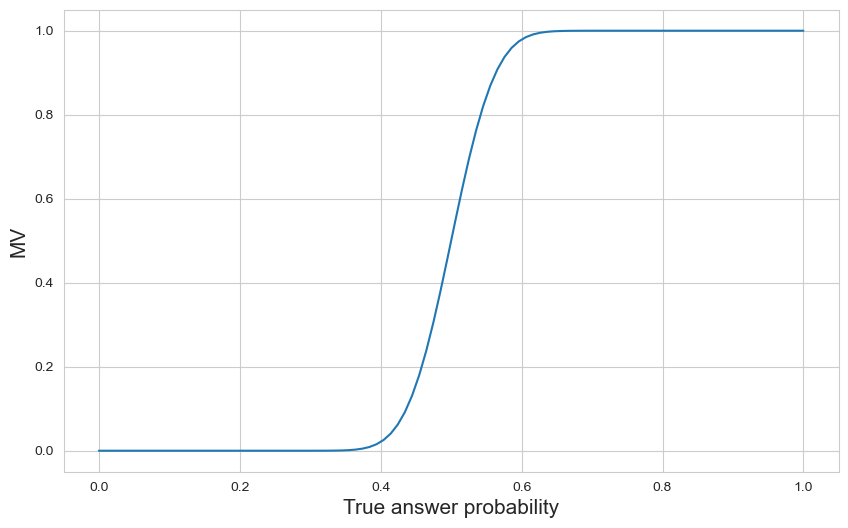

In [8]:
p = np.linspace(0, 1, 100)

mv = [sum(comb(101, i) * (p ** i) * ((1 - p) ** (101 - i)) for i in range(51, 102)) for p in p]

plt.figure(figsize=(10, 6))
plt.plot(p, mv)
plt.xlabel('True answer probability', fontsize=15)
plt.ylabel('MV', fontsize=15)
plt.show()

А теперь давайте посмотрим на другую ситуацию. У нас есть фиксированная вероятность того, что модель правильно классифицирует объект `p = 0.65`. Постройте зависимость вероятности правильно классифицировать объект от числа моделей в ансамбле.

In [9]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

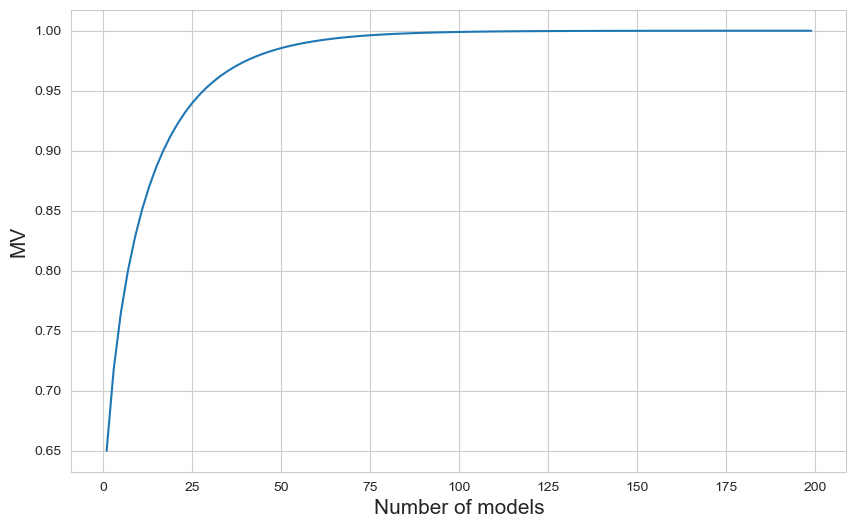

In [10]:
n = np.arange(1, 200, 2)

mv = [sum(comb(n, i) * (0.65 ** i) * ((1 - 0.65) ** (n - i)) for i in range((n + 1) // 2, n + 1)) for n in n]

plt.figure(figsize=(10, 6))
plt.plot(n, mv)
plt.xlabel('Number of models', fontsize=15)
plt.ylabel('MV', fontsize=15)
plt.show()

Опишите ваши наблюдения:

* Как только вероятность правильного ответа становится больше половины (0.6), то majority vote дает очень неплохие предсказания при фиксированном числе моделей.
* При вероятности предсказания больше половины (0.65 - чуть больше, но суть в целом та же), начиная от 25 моделей мы можем уверенно предсказывать целевую переменную по majority vote с вероятностью около 94%. Со 100 моделей вероятность правильного предсказания выходит на плато.

#### Задание 2. 2. Реализация простого RF

**4 балла**

Реализуйте свой собственный класс `RandomForestClassifierCustom`, используя в качестве базовой модели `DecisionTreeClassifier` из `sklearn`.

Небольшое описание:
- Используйте приведенный ниже код
- В методе `fit` в цикле (`i` от 0 до `n_estimators-1`):
    * Зафиксируйте генератор случайных чисел следующим образом np.random.seed(`random_state + i`). Идея в том, что на каждой итерации у нас будет новое значение для генератора случайных чисел, что добавит побольше "случайности", но в то же время мы сможем иметь воспроизводимые результаты
    * После чего выберите `max_features` признаков **без возвращения/without replacement**, сохраните список выбранных признаков (их индексов) в `self.feat_ids_by_tree`
    * Также создайте псевдовыборку при помощи бутстрэпа (выбор **с возвращением/with replacement**) из тренировочных данных. Может помочь функция `np.random.choice` и ее аргумент `replace`
    * Обучите дерево решений с параметрами, заданными в конструкторе класса `max_depth`, `max_features` и `random_state` на полученной псевдовыборке.
- Метод `fit` должен возвращать текущий экземпляр класса `RandomForestClassifierCustom`, то есть `self` (все по-взрослому, как в `sklearn`)
- В методе `predict_proba` мы должны пройти циклом по всем деревьям. Для каждого предсказания, нам нужно будет брать только те признаки, на которых училось изначальное дерево, поэтому мы и сохраняли эту информацию в артрибуте `self.feat_ids_by_tree`. Этот метод должен возвращать предсказанные вероятности (можно делать двумя способами: для каждого дерева предсказывать значение при помощи метода `predict_proba` и потом усреднять эти вероятности, или к примеру пользоваться методом `predict` и также считать среднее.

In [11]:
class RandomForestClassifierCustom(BaseEstimator):
    def __init__(
        self, n_estimators=10, max_depth=None, max_features=None, random_state=SEED
    ):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.max_features = max_features
        self.random_state = random_state

        self.trees = []
        self.feat_ids_by_tree = []

    def fit(self, X, y):
        self.classes_ = sorted(np.unique(y))
        
        ## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##
        for i in range(self.n_estimators):
            np.random.seed(self.random_state + i)
            feat_idx = np.random.choice(X.shape[1], self.max_features, replace=False)
            self.feat_ids_by_tree.append(feat_idx)

            bootstrap_idx = np.random.choice(X.shape[0], X.shape[0], replace=True)
            bootstrap_X = X[bootstrap_idx]
            bootstrap_y = y[bootstrap_idx]

            drevo = DecisionTreeClassifier(max_depth=self.max_depth, random_state=(self.random_state+i))
            drevo.fit(bootstrap_X[:, feat_idx], bootstrap_y)
            
            self.trees.append(drevo)
            
        return self

    def predict_proba(self, X):
        ## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##
        probas = []
        
        for tree, feat_idx in zip(self.trees, self.feat_ids_by_tree):
            probas.append(tree.predict_proba(X[:, feat_idx]))
        
        return np.mean(probas, axis=0)
    
    def predict(self, X):
        probas = self.predict_proba(X)
        predictions = np.argmax(probas, axis=1)
        
        return predictions

Протестируем нашу реализацию на искусственных данных. Визуализируйте разделяющую границу, которую рисует ваша модель при помощи функции `plot_decision_boundary` (см. примеры в лекции).

In [12]:
def plot_decision_boundary(clf, X, y, ax, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(["#ffdab9","#9898ff", "#4B0082"])
    ax.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(["#ffdab9", "#4c4c7f", "#4B0082"])
        ax.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    ax.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    ax.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    ax.axis(axes)
    ax.set_xlabel(r"$x_1$", fontsize=18)
    ax.set_ylabel(r"$x_2$", fontsize=18, rotation=0)

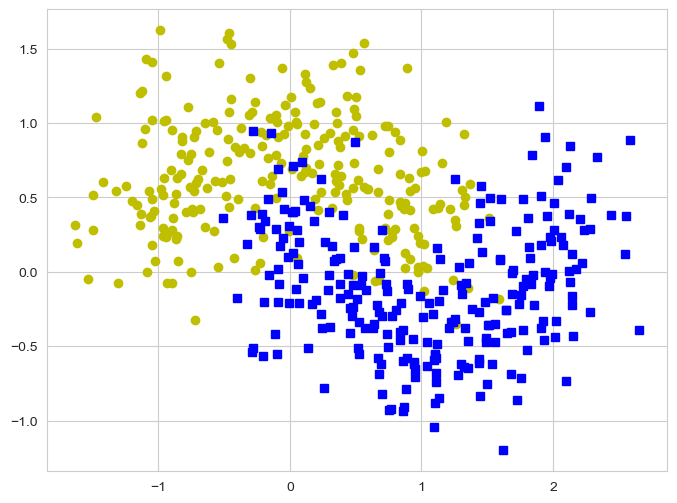

In [13]:
X, y = datasets.make_moons(n_samples=500, noise=0.30, random_state=SEED)

plt.figure(figsize=(8, 6))
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo")
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs")
plt.show()

In [14]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

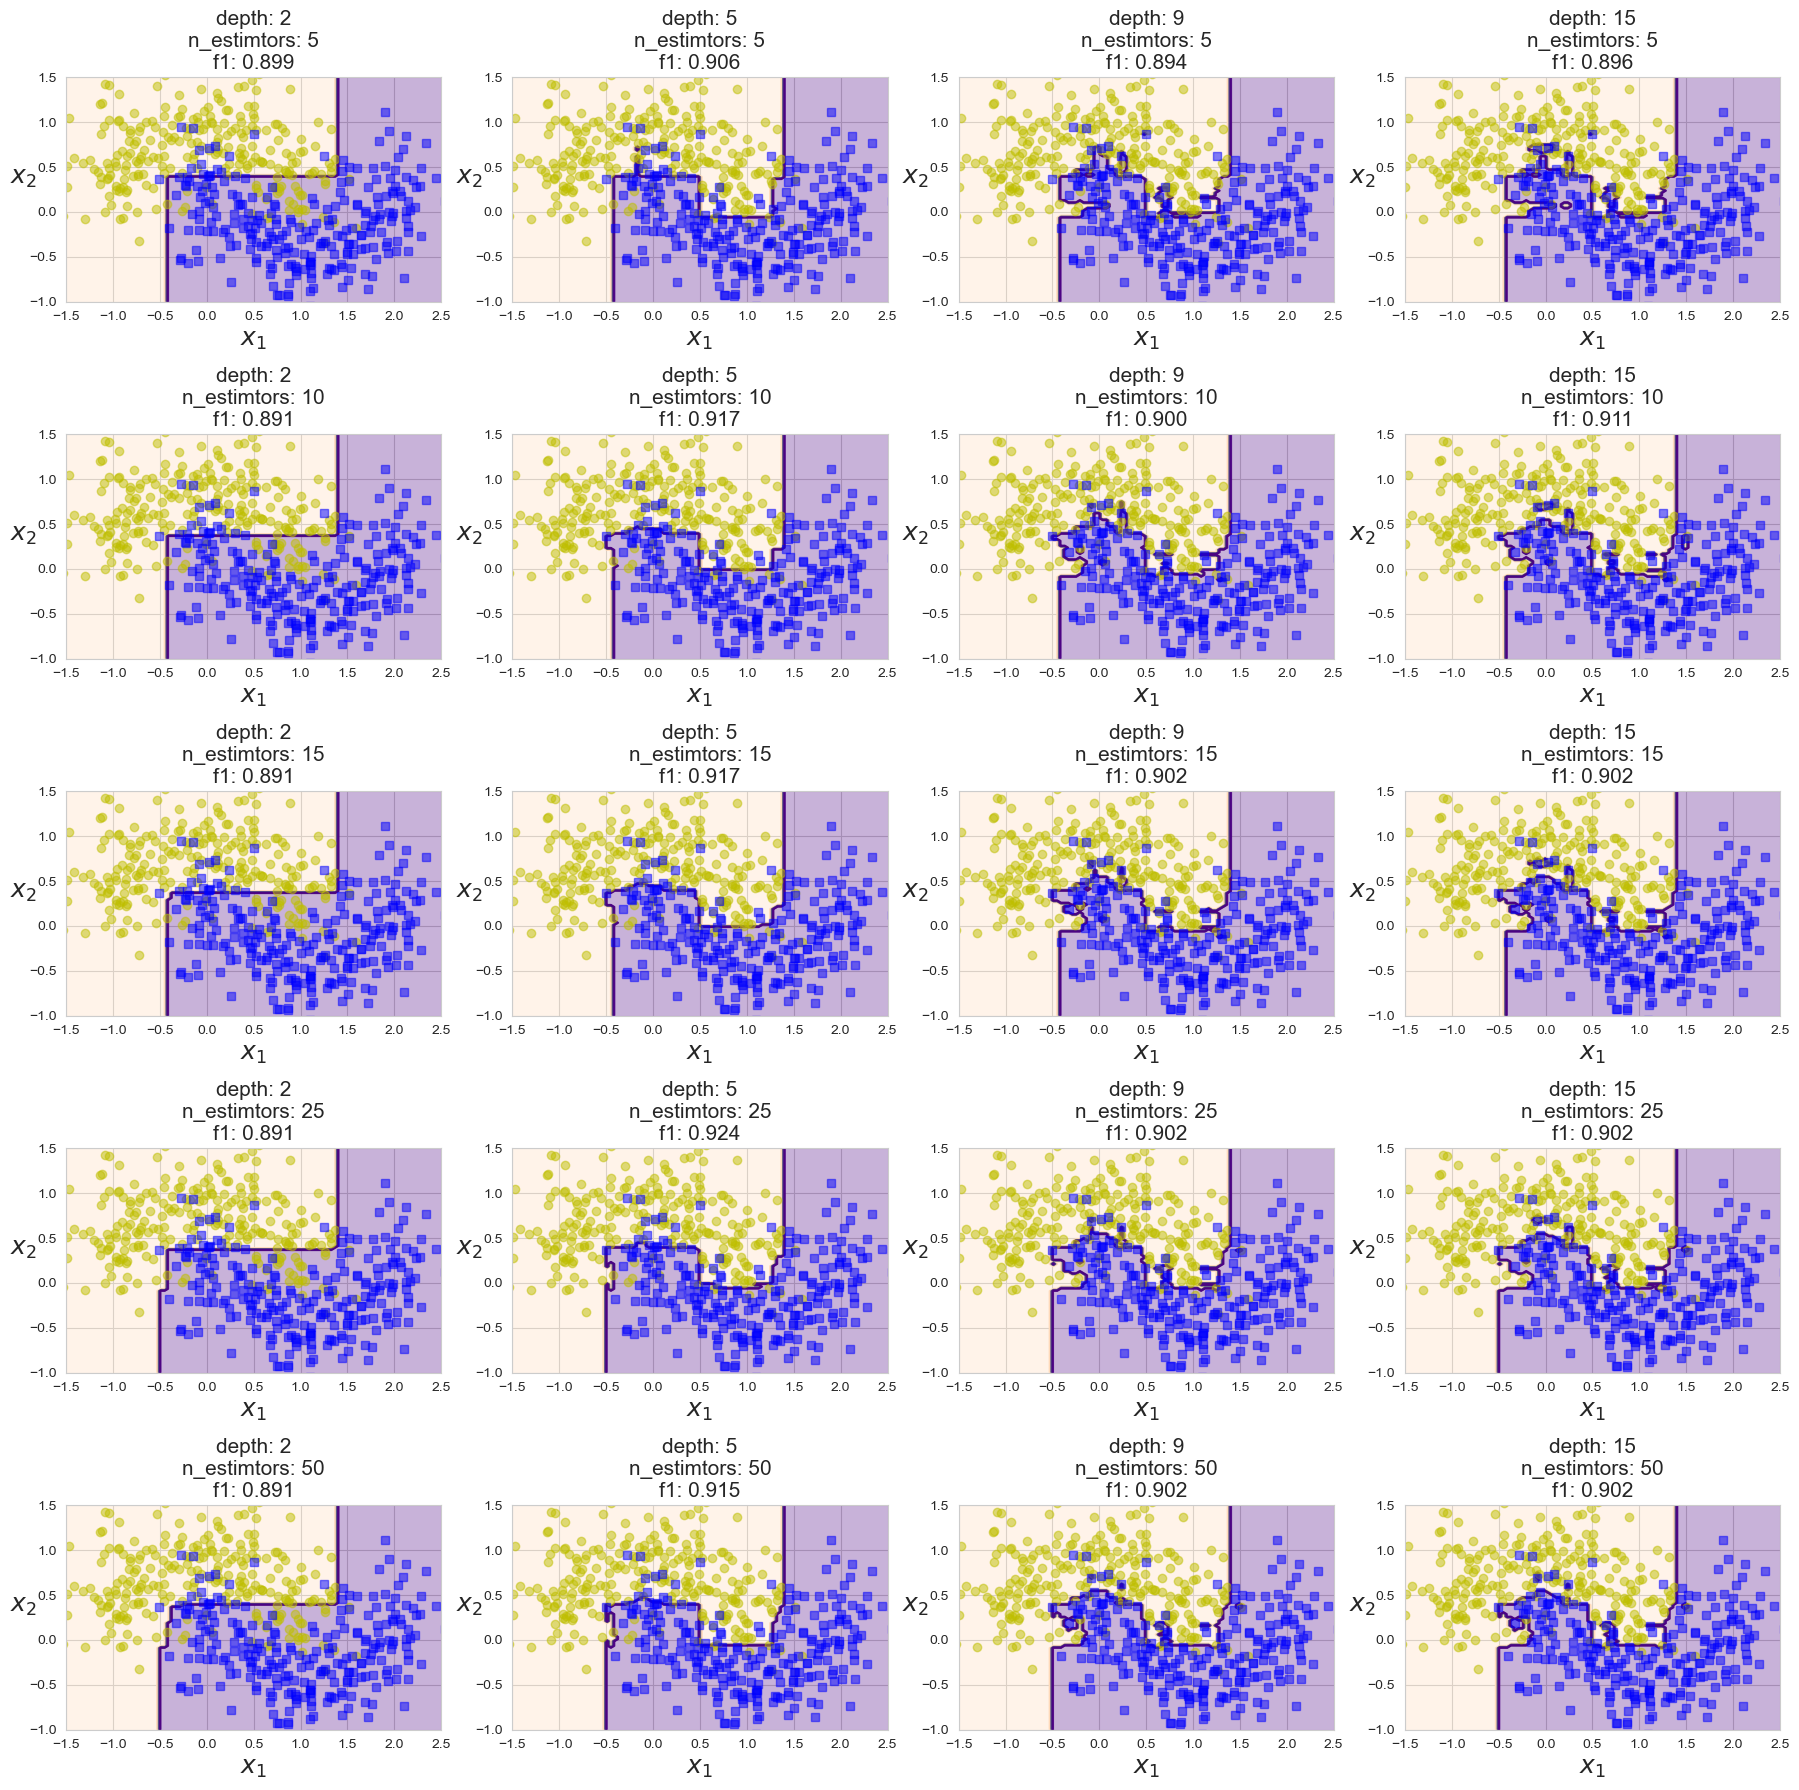

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)

n_estimators = [5, 10, 15, 25, 50]
n_depths = [2, 5, 9, 15]

fig, axs = plt.subplots(5, 4, figsize=(18, 18))
axs = axs.flatten()

idx = 0
for estimator in n_estimators:
    for depth in n_depths:
        drevo_class = RandomForestClassifierCustom(n_estimators=estimator, max_depth=depth, max_features=2, random_state=SEED)
        drevo_class.fit(X_train, y_train)
        y_pred = drevo_class.predict(X_test)
        f1 = f1_score(y_test, y_pred)
        plot_decision_boundary(drevo_class, X, y, axs[idx])
        axs[idx].set_title(f"depth: {depth}\nn_estimtors: {estimator}\nf1: {f1:.3f}", fontsize=15)
        idx += 1

plt.tight_layout()
plt.show()

Подберите наилучшие гиперпараметры, при которых разделяющая граница будет, на ваш взгляд, оптимальной с точки зрения bias-variance. Можно также подключить какие-то метрики для выбора лучшей модели.

In [16]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

**Внешне и по f1 лучше всего выглядит модель при depth=5, n_estimators=25**

#### Задание 2. 3. Корреляция базовых моделей

**3 балла**

Как мы выянили на лекции, для того, чтобы bagging работал хорошо, предсказания наших моделей не должны сильно коррелировать. Для этого в случайном лесе применяются различные подходы, в том числе и RSM. Давайте посмотрим, как влияет параметр `max_features` на корреляцию базовых моделей в случайном лесу из `sklearn`. В качестве примера будем использовать датасет `breast_cancer`. Для расчета корреляций используйте приведенную ниже функцию `base_model_pair_correlation`. Для каждой модели у вас будет получаться набор значений (попарные корреляции всех деревьев), дальше можно изобразить их в виде боксплотов, как мы на лекции рисовали распределение метрик.

In [17]:
# Функция для расчета попарных корреляций базовых моделей в случайном лесу
def base_model_pair_correlation(ensemble, X):
    corrs = []
    for (i, est1), (j, est2) in combinations(enumerate(ensemble.estimators_), 2):
        Xi_test = X
        Xj_test = X

        ypred_t1 = est1.predict_proba(Xi_test)[:, 1]
        ypred_t2 = est2.predict_proba(Xj_test)[:, 1]

        corrs.append(pearsonr(ypred_t1, ypred_t2)[0])
    return np.array(corrs)

In [18]:
# Загрузим данные
breast_cancer = datasets.load_breast_cancer()
X = breast_cancer.data
y = breast_cancer.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [19]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

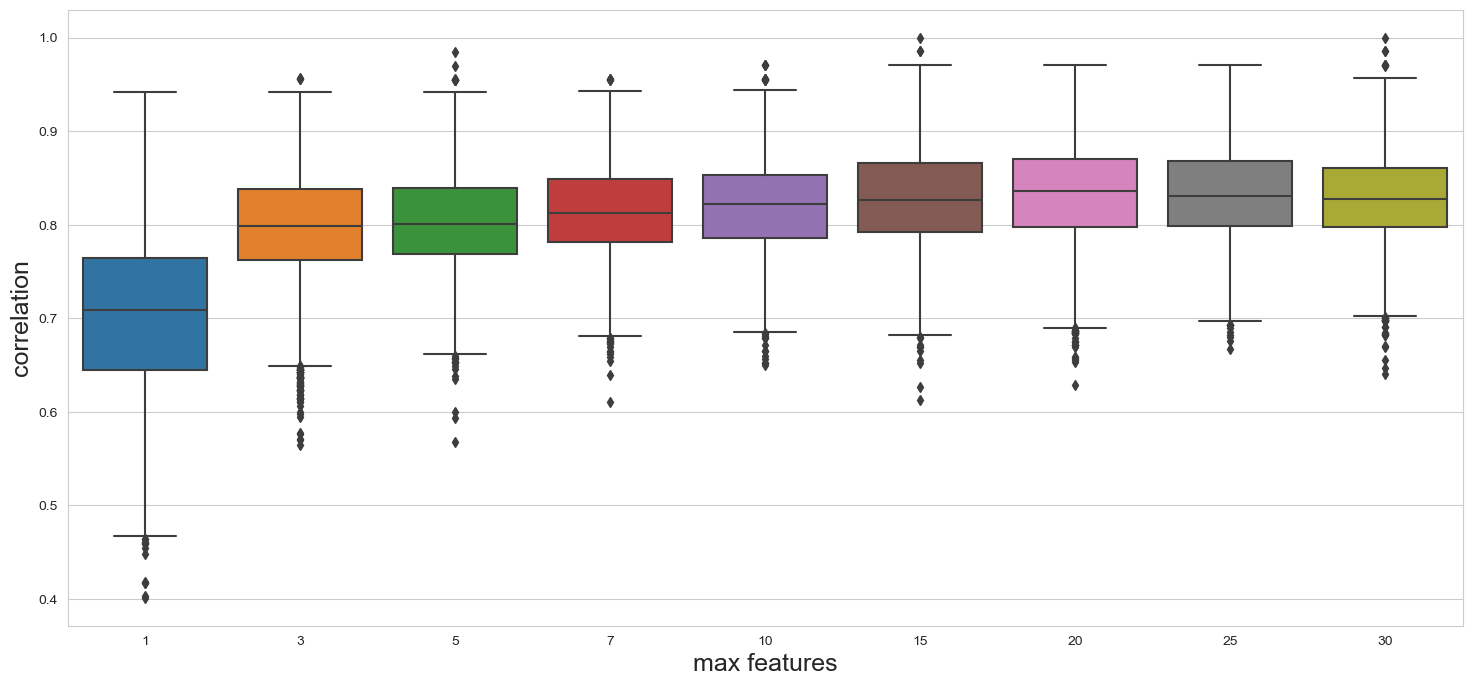

In [20]:
max_features = [1, 3, 5, 7, 10, 15, 20, 25, 30]
cors = pd.DataFrame()

for max_feature in max_features:
    tree_cl = RandomForestClassifier(max_features=max_feature)
    tree_cl.fit(X_train, y_train)
    cors[max_feature] = base_model_pair_correlation(tree_cl, X_test)

plt.figure(figsize=(18, 8))
sns.boxplot(data=cors)
plt.xlabel("max features", size=18)
plt.ylabel("correlation", size=18)
plt.show()

Теперь давайте посмотрим, как на это влияет параметр `max_depth`:

In [21]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

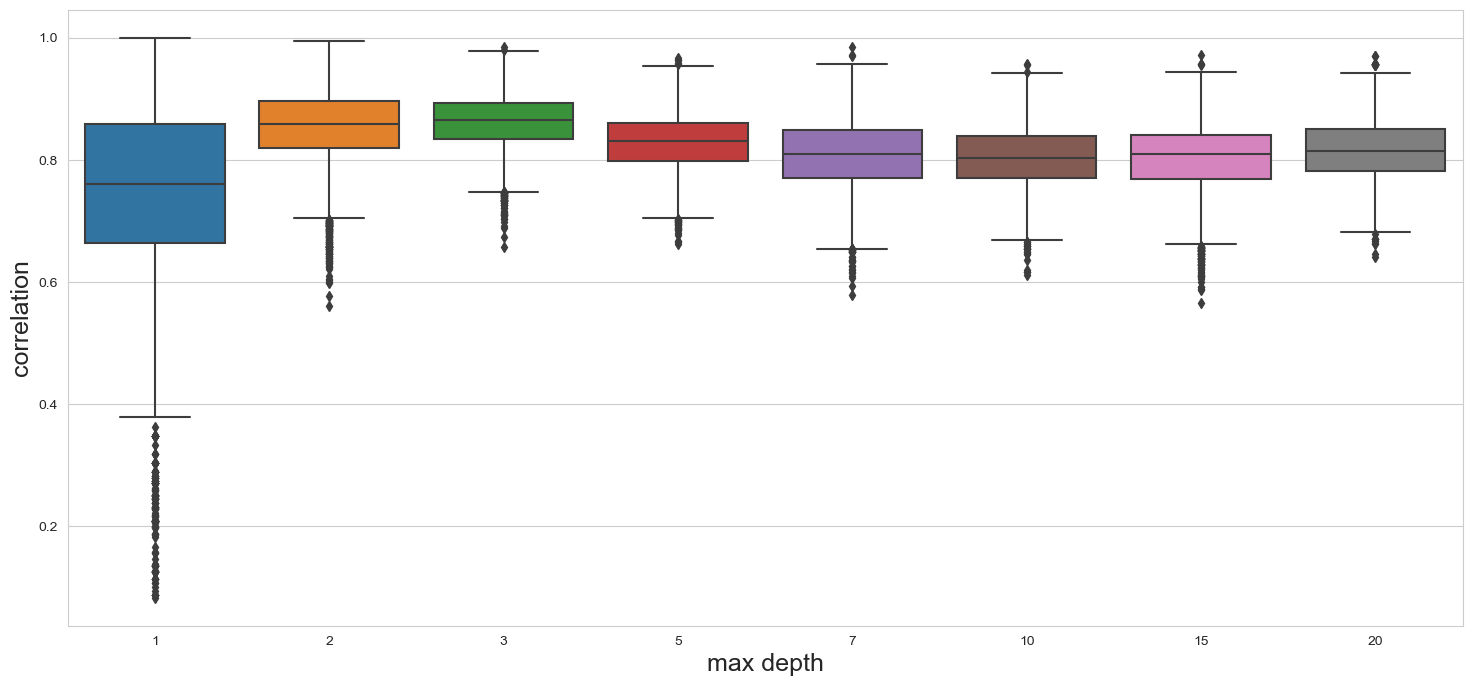

In [22]:
max_depths = [1, 2, 3, 5, 7, 10, 15, 20]
cors = pd.DataFrame()

for max_depth in max_depths:
    tree_cl = RandomForestClassifier(max_depth=max_depth)
    tree_cl.fit(X_train, y_train)
    cors[max_depth] = base_model_pair_correlation(tree_cl, X_test)

plt.figure(figsize=(18, 8))
sns.boxplot(data=cors)
plt.xlabel("max depth", size=18)
plt.ylabel("correlation", size=18)
plt.show()

Опишите ваши наблюдения:

* Чем больше max_features, тем больше корреляции моделей, но с определенного момента (здесь при 5 features) она выходит на плато.
* При максимальной глубине 1 корреляции могут быть любыми. C 2 до 3 есть рост, но затем корреляции падают и тоже выходят на плато.

### Задание 3. Строим большой ансамбль

**4 балла + 3 дополнительных за скор выше 0.87**

В данной задаче вам нужно диагностировать сердечное заболевание у людей по медицинским показателям.

In [23]:
#!gdown  --id 1VFbDK-Ad-hpf0_GGCBzn4thdn9mkQ-Y- -O heart.csv -q
heart_dataset = pd.read_csv("../data/heart.csv")

In [24]:
X = heart_dataset.drop("target", axis=1)
y = heart_dataset["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)
X_train.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
178,43,1,0,120,177,0,0,120,1,2.5,1,0,3
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3
201,60,1,0,125,258,0,0,141,1,2.8,1,1,3
246,56,0,0,134,409,0,0,150,1,1.9,1,2,3
153,66,0,2,146,278,0,0,152,0,0.0,1,1,2


Обучите разнообразные классификаторы, приведенные ниже, а также ансамбль `VotingClassifier` из `sklearn.ensemble`, объединяющий эти классификаторы с помощью жесткого или мякого голосования (параметр `voting =` `'hard'` или `'soft'` соответственно). Оцените качество моделей с помощью кросс-валидации на тренировочном наборе, используя функцию `cross_val_score` и метрику `f1`. Часть моделей отсюда мы не проходили, о них можно почитать дополнительно, но в принципе для задания не очень важно знать принципы их работы (но, если есть время, то почитайте, там интересно).

In [25]:
dt = DecisionTreeClassifier(random_state=SEED, max_depth=10, min_samples_leaf=10)
rf = RandomForestClassifier(n_estimators=50, random_state=SEED)
etc = ExtraTreesClassifier(random_state=SEED)
knn = KNeighborsClassifier(n_neighbors=5, weights="distance")
svc_lin = SVC(kernel='linear', probability=True, random_state=SEED)
svc_rbf = SVC(kernel='rbf', probability=True, random_state=SEED)
cat = catboost.CatBoostClassifier(verbose=0, random_seed=SEED)
lgbm = lightgbm.LGBMClassifier(random_state=SEED)
lgbm_rf = lightgbm.LGBMClassifier(boosting_type="rf", bagging_freq=1, bagging_fraction=0.7, random_state=SEED)
xgb = xgboost.XGBClassifier(random_state=SEED)
xgb_rf = xgboost.XGBRFClassifier(random_state=SEED)
lr = LogisticRegression(solver='liblinear', max_iter=10000)
nb = GaussianNB()

base_models = [("DT", dt), ("RF", rf), 
               ("ETC", etc), ("KNN", knn), 
               ("SVC_LIN", svc_lin), ("SVC_RBF", svc_rbf), 
               ("CAT", cat), ("LGBM", lgbm), 
               ("LGBM_RF", lgbm_rf), ("XGB", xgb), 
               ("XGB_RF", xgb_rf), ("LR", lr), ("NB", nb)]

Здесь могут возникать различные предупреждения при обучении бустингов, не волнуйтесь, все нормально, просто они обычно очень разговорчивые)

In [26]:
%%capture

## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##
voting_hard = VotingClassifier(estimators=base_models, voting='hard')
voting_soft = VotingClassifier(estimators=base_models, voting = 'soft')


## END YOUR CODE HERE ##
scores_dict = {}
for idx, model in enumerate([dt, rf, cat, etc, knn, svc_lin, svc_rbf, xgb, lgbm, xgb_rf, lgbm_rf, lr, nb, voting_hard, voting_soft]): 
    scores_dict[f'Model {idx} {model.__class__.__name__}'] = cross_val_score(model, X_train, y_train, cv=3, scoring="f1")

In [27]:
for model in scores_dict.keys(): 
    print(f"{model}: {scores_dict[model].mean()}")

Model 0 DecisionTreeClassifier: 0.797997226792219
Model 1 RandomForestClassifier: 0.8328751280279528
Model 2 CatBoostClassifier: 0.8342715174922052
Model 3 ExtraTreesClassifier: 0.8281746031746032
Model 4 KNeighborsClassifier: 0.6493313763861709
Model 5 SVC: 0.8403098469098905
Model 6 SVC: 0.6973119072190279
Model 7 XGBClassifier: 0.820158269808819
Model 8 LGBMClassifier: 0.817010631644778
Model 9 XGBRFClassifier: 0.8396975787156665
Model 10 LGBMClassifier: 0.8132478632478634
Model 11 LogisticRegression: 0.8500073681108163
Model 12 GaussianNB: 0.8140676625250128
Model 13 VotingClassifier: 0.8395804737268152
Model 14 VotingClassifier: 0.8455110375195781


Вы можете заметить, что ансамбль показывает хорошее, но не лучшее качество предсказания, попробуем его улучшить. Как вы знаете, ансамбли работают лучше, когда модели, входящие в них не скоррелированы друг с другом. Определите корреляцию предсказаний базовых моделей в ансамбле на тестовом наборе данных, и удалите из ансамбля те модели, чьи предсказания будут сильнее коррелировать с остальными. Воспользуйтесь функцией `base_model_pair_correlation_for_voting_clf`. **Спойлер**: далеко не факт, что если вы удалите две модели с корреляцией 0.95, то все станет сильно лучше, здесь все будет немного сложнее. Чтобы добиться максимального качества может понадобиться долгий перебор различных комбинаций моделей. Наилучший скор, который мне удалось достичь, это 0.915, но он получен весьма странной комбинацией алгоритмов, а еще и простым перебором всех вариантов)

In [28]:
def base_model_pair_correlation_for_voting_clf(ensemble, X):
    corrs = []
    base_model_names = [f"{est.__class__.__name__}" for est in ensemble.estimators_]
    for (i, est1), (j, est2) in combinations(enumerate(ensemble.estimators_), 2):
        Xi_test = X
        Xj_test = X

        if not isinstance(est1, SVC):
            ypred_t1 = est1.predict_proba(Xi_test)[:, 1]
        else:
            ypred_t1 = est1.decision_function(Xi_test)


        if not isinstance(est2, SVC):
            ypred_t2 = est2.predict_proba(Xi_test)[:, 1]
        else:
            ypred_t2 = est2.decision_function(Xi_test)
        corrs.append((est1, est2, pearsonr(ypred_t1, ypred_t2)[0]))


    return corrs

In [29]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

In [30]:
%%capture
voting_soft = VotingClassifier(estimators=base_models, voting = 'soft')
voting_soft.fit(X_train, y_train)
correlations = base_model_pair_correlation_for_voting_clf(voting_soft, X_test)

**Оценим, какие модели наиболее скоррелированы**

In [31]:
for idx in range(len(correlations)):
    if correlations[idx][2] > 0.95:
        print(correlations[idx][0].__class__.__name__, correlations[idx][1].__class__.__name__, 'correlation:', correlations[idx][2])

ExtraTreesClassifier CatBoostClassifier correlation: 0.9527199736215164
SVC LogisticRegression correlation: 0.9521587720597199
CatBoostClassifier LGBMClassifier correlation: 0.9552781313087827
LGBMClassifier XGBClassifier correlation: 0.9634394086243608


In [32]:
for idx in range(len(correlations)):
    if correlations[idx][2] > 0.95:
        print(correlations[idx][0], correlations[idx][1], 'correlation:', correlations[idx][2])

ExtraTreesClassifier(random_state=111) <catboost.core.CatBoostClassifier object at 0x169049340> correlation: 0.9527199736215164
SVC(kernel='linear', probability=True, random_state=111) LogisticRegression(max_iter=10000, solver='liblinear') correlation: 0.9521587720597199
<catboost.core.CatBoostClassifier object at 0x169049340> LGBMClassifier(random_state=111) correlation: 0.9552781313087827
LGBMClassifier(random_state=111) XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_chi

In [33]:
bad_models = [("ETC", etc), ("CAT", cat),("SVC_LIN", svc_lin), ("LGBM", lgbm), ("LR", lr), ("XGB", xgb)]

**Попробую удалить их все**

In [34]:
new_models1 = [item for item in base_models if item not in bad_models]

In [35]:
%%capture
voting_soft1 = VotingClassifier(estimators=new_models1, voting = 'soft')
voting_soft1.fit(X_train, y_train)
result1 = cross_val_score(voting_soft1, X_train, y_train, cv=3, scoring="f1").mean()

In [36]:
result1 #Стало хуже...

0.8364672364672364

**Попробую другой подход: буду удалять по 1ой модели**

In [37]:
def model_finder(bad_models, base_models):
    results = {}
    for bad_model in bad_models:
        new_models = []
        new_models.extend([item for item in base_models if item != bad_model])
        voting_soft = VotingClassifier(estimators=new_models, voting = 'soft')
        voting_soft.fit(X_train, y_train)
        result = cross_val_score(voting_soft, X_train, y_train, cv=3, scoring="f1").mean()
        results[bad_model[0]] = result
    return results

In [38]:
%%capture
results = model_finder(bad_models, base_models)

In [39]:
results

{'ETC': 0.8550318922749822,
 'CAT': 0.8455110375195781,
 'SVC_LIN': 0.8455110375195781,
 'LGBM': 0.8441585514756248,
 'LR': 0.8455110375195781,
 'XGB': 0.8414707655213984}

**Если удалить ETC, то станет лучше! Попробую удалить следующую модель**

In [40]:
base_models2 = [("DT", dt), ("RF", rf), ("KNN", knn), 
               ("SVC_LIN", svc_lin), ("SVC_RBF", svc_rbf), 
               ("CAT", cat), ("LGBM", lgbm), 
               ("LGBM_RF", lgbm_rf), ("XGB", xgb), 
               ("XGB_RF", xgb_rf), ("LR", lr), ("NB", nb)]
bad_models2 = [("CAT", cat),("SVC_LIN", svc_lin), ("LGBM", lgbm), ("LR", lr), ("XGB", xgb)]

In [41]:
%%capture
results = model_finder(bad_models2, base_models2)

In [42]:
results

{'CAT': 0.8503633581946834,
 'SVC_LIN': 0.8501795715998769,
 'LGBM': 0.8455110375195781,
 'LR': 0.8503633581946834,
 'XGB': 0.8414707655213984}

**Как и говорилось, тут так просто подойти не получится...**

### Задание 4. Определение оттока клиентов из телекома

**6 баллов + 7 дополнительных за высокое качество модели и различные эксперименты**

Будем предсказывать, уйдет ли от нас клиент (переменная `Churn?`). Данные можно скачать [здесь](https://www.kaggle.com/venky12347/churn-telecom). Это будет уже совсем взрослое задание, так как правильного ответа на него нет. Вам нужно будет разобраться с данными, правильно подготовить их для моделей, а также выбрать лучшую модель. 

Задача минимум:

Выберите 2 модели &mdash; один случайный лес и один бустинг из приведенных ниже:

1. `xgboost.XGBClassifier`
2. `xgboost.XGBRFClassifier` &mdash; случайный лес от xgboost
3. `lightgbm.LGBMClassifier`
4. `lightgbm.LGBMClassifier(boosting_type="rf")` &mdash; случайный лес от lightgbm
5. `catboost.CatBoostClassifier`

И попробуйте разобраться с тем, как для этих моделей правильно настраивать гиперпараметры. Советую гуглить примерно следующее `how to choose best hyperparameters for lightgbm`. Там вы найдете кучу сложного и непонятного кода, но если с ним разобраться и научиться обучать нестандартные бустинги, то в плане табличных данных равных вам не будет)

In [43]:
data = pd.read_csv("../data/churn.csv")
data.head()

,State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,...,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False.
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False.
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False.
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False.
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False.


In [44]:
data.shape

(3333, 21)

In [45]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   State           3333 non-null   object 
 1   Account Length  3333 non-null   int64  
 2   Area Code       3333 non-null   int64  
 3   Phone           3333 non-null   object 
 4   Int'l Plan      3333 non-null   object 
 5   VMail Plan      3333 non-null   object 
 6   VMail Message   3333 non-null   int64  
 7   Day Mins        3333 non-null   float64
 8   Day Calls       3333 non-null   int64  
 9   Day Charge      3333 non-null   float64
 10  Eve Mins        3333 non-null   float64
 11  Eve Calls       3333 non-null   int64  
 12  Eve Charge      3333 non-null   float64
 13  Night Mins      3333 non-null   float64
 14  Night Calls     3333 non-null   int64  
 15  Night Charge    3333 non-null   float64
 16  Intl Mins       3333 non-null   float64
 17  Intl Calls      3333 non-null   i

**Пропущенных нет**

In [46]:
data.describe()

,Account Length,Area Code,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls
count,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000
mean,101.064806,437.182418,8.099010,179.775098,100.435644,30.562307,200.980348,100.114311,17.083540,200.872037,100.107711,9.039325,10.237294,4.479448,2.764581,1.562856
std,39.822106,42.371290,13.688365,54.467389,20.069084,9.259435,50.713844,19.922625,4.310668,50.573847,19.568609,2.275873,2.791840,2.461214,0.753773,1.315491
min,1.000000,408.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.200000,33.000000,1.040000,0.000000,0.000000,0.000000,0.000000
25%,74.000000,408.000000,0.000000,143.700000,87.000000,24.430000,166.600000,87.000000,14.160000,167.000000,87.000000,7.520000,8.500000,3.000000,2.300000,1.000000
50%,101.000000,415.000000,0.000000,179.400000,101.000000,30.500000,201.400000,100.000000,17.120000,201.200000,100.000000,9.050000,10.300000,4.000000,2.780000,1.000000
75%,127.000000,510.000000,20.000000,216.400000,114.000000,36.790000,235.300000,114.000000,20.000000,235.300000,113.000000,10.590000,12.100000,6.000000,3.270000,2.000000
max,243.000000,510.000000,51.000000,350.800000,165.000000,59.640000,363.700000,170.000000,30.910000,395.000000,175.000000,17.770000,20.000000,20.000000,5.400000,9.000000


In [47]:
data.nunique()

State               51
Account Length     212
Area Code            3
Phone             3333
Int'l Plan           2
VMail Plan           2
VMail Message       46
Day Mins          1667
Day Calls          119
Day Charge        1667
Eve Mins          1611
Eve Calls          123
Eve Charge        1440
Night Mins        1591
Night Calls        120
Night Charge       933
Intl Mins          162
Intl Calls          21
Intl Charge        162
CustServ Calls      10
Churn?               2
dtype: int64

**Из того, что видно - Area code, оба Plan надо перевести в фактор. Номера телефонов Phone нужно дропнуть, т.к. все значения уникальные**

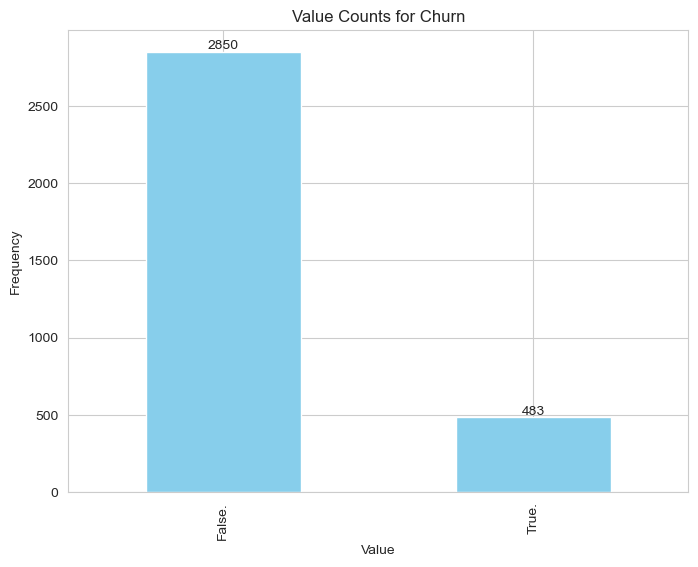

In [48]:
plt.figure(figsize=(8, 6))
data['Churn?'].value_counts().plot(kind='bar', color='skyblue')
plt.title(f'Value Counts for Churn')
plt.xlabel('Value')
plt.ylabel('Frequency')
for i, v in enumerate(data['Churn?'].value_counts()):
    plt.text(i, v + 0.1, str(v), ha='center', va='bottom')
plt.grid(True)
plt.show()

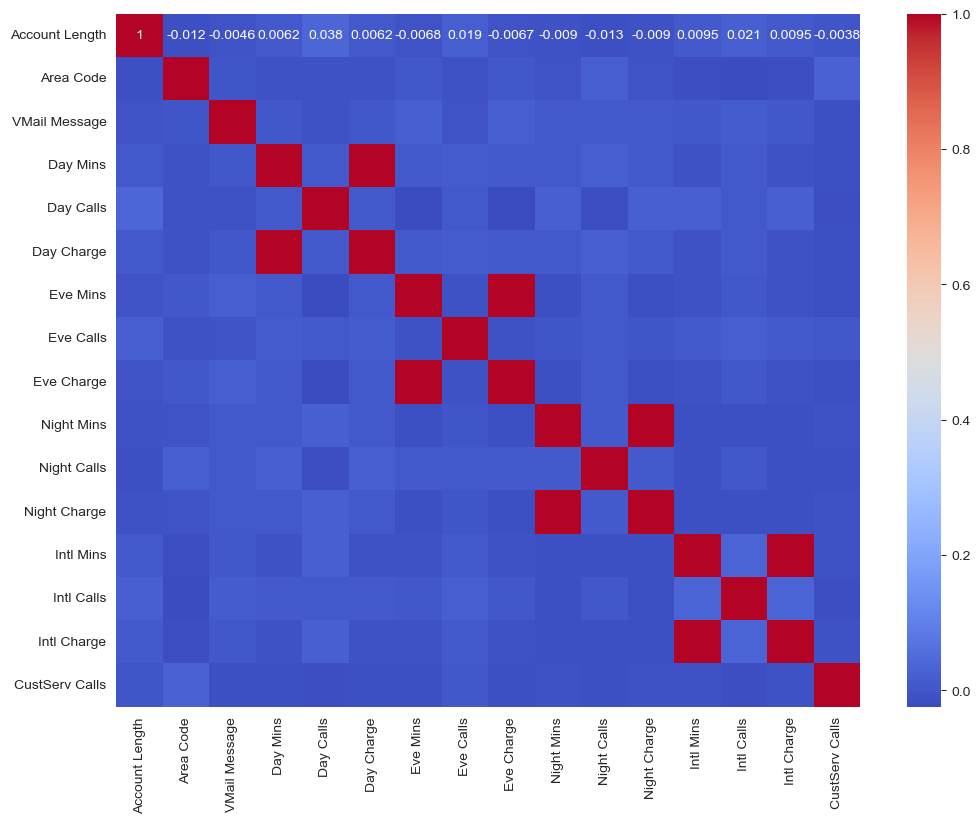

In [49]:
correlation_matrix = data.select_dtypes(include=['int64', 'float64']).corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')  

plt.show()

**Переменные с charge я пожалуй дропну тоже**

**Достаточно суровый дисбаланс классов в целевой переменной**

In [50]:
data = data.drop('Phone', axis = 1)

data = data.drop(['Day Charge', 'Eve Charge', 'Night Charge','Intl Charge'], axis = 1)

In [51]:
map_dict = {
    "False.": 0,
    "True.": 1
}

data.replace({"Churn?": map_dict}, inplace=True) #перевод в нормальные значения

In [52]:
y = data['Churn?'].values
X = data.drop('Churn?', axis=1)

cat_cols = ['State', 'Area Code', 'Int\'l Plan', 'VMail Plan']

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)

## Boosting

In [54]:
ohe = make_column_transformer(
    (OneHotEncoder(drop="first"),
     cat_cols),
     remainder='passthrough')


boosting_pipeline1 = Pipeline(steps=[
    ("ohe", ohe),
    ("boost", xgboost.XGBClassifier(random_state=SEED))])
boosting_pipeline1

Pipeline(steps=[('ohe',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='first'),
                                                  ['State', 'Area Code',
                                                   "Int'l Plan",
                                                   'VMail Plan'])])),
                ('boost',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categoric...
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=111, ...))])

**Со стандартными параметрами:**

In [55]:
boosting_pipeline1.fit(X_train, y_train)
y_pred = boosting_pipeline1.predict(X_test)
f1_score(y_test, y_pred)

0.7884615384615384

**Так себе. Попробую отрегулировать гиперпараметры**

**Попробую подобрать с помощью gridsearch**

In [56]:
params = [{
    'boost__eta': [0.1, 0.15, 0.3, 0.5],
    'boost__subsample': [0.5, 0.7, 0.8],
    'boost__max_depth': [6, 11, 16],
    'boost__scale_pos_weight': [0, 3, 5, 7] #есть дисбаланс классов
    }]


gs_boost = GridSearchCV(boosting_pipeline1, 
                      param_grid=params, 
                      scoring='f1', 
                      cv=5)
gs_boost.fit(X_train, y_train)
y_pred = gs_boost.predict(X_test)
print(f1_score(y_test, y_pred))
gs_boost.best_params_

0.8440366972477065


{'boost__eta': 0.15,
 'boost__max_depth': 6,
 'boost__scale_pos_weight': 3,
 'boost__subsample': 0.8}

**Так то лучше)) P.s. n_estimators не трогал, т.к. его изменения на нестандартные почему-то у меня портят модель**

In [57]:
boosting_pipeline_best = Pipeline(steps=[
    ("ohe", ohe),
    ("boost", xgboost.XGBClassifier(eta = 0.15, max_depth = 6, scale_pos_weight = 3, subsample = 0.8, random_state=SEED))])

In [58]:
boosting_pipeline_best.fit(X_train, y_train)
y_pred = boosting_pipeline_best.predict(X_test)
f1_score(y_test, y_pred)

0.8440366972477065

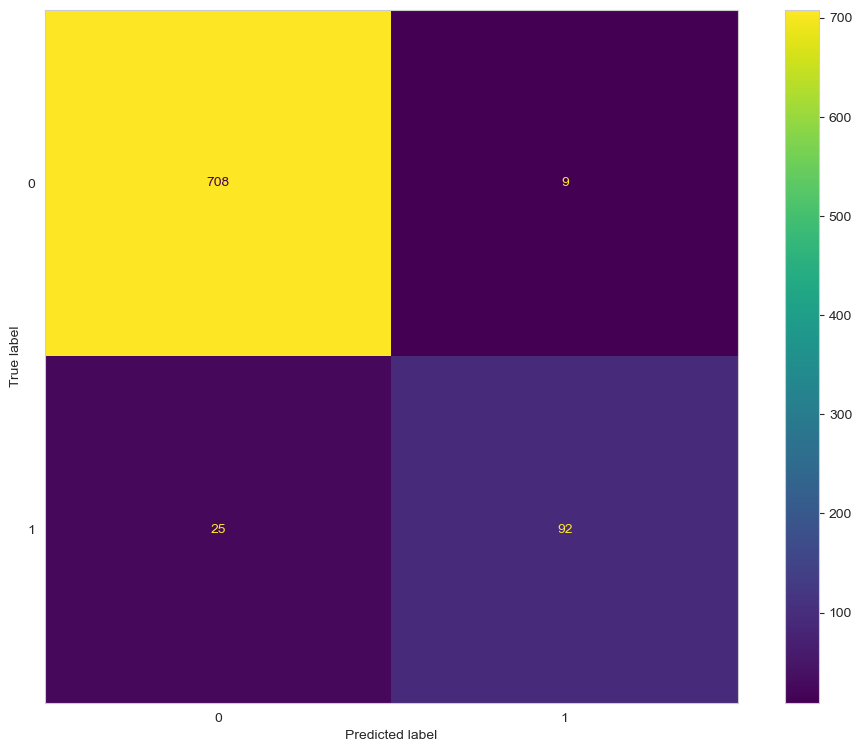

In [59]:
conf_matrix = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(conf_matrix).plot()
plt.grid(False);

## Случайный лес

In [60]:
forest_pipeline = Pipeline(steps=[
    ("ohe", ohe),
    ("boost", xgboost.XGBRFClassifier(random_state=SEED))])
forest_pipeline

Pipeline(steps=[('ohe',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='first'),
                                                  ['State', 'Area Code',
                                                   "Int'l Plan",
                                                   'VMail Plan'])])),
                ('boost',
                 XGBRFClassifier(base_score=None, booster=None, callbacks=None,
                                 colsample_bylevel=None, colsample_bytree=None,
                                 early_stopping_rounds=None,
                                 enable_categorical=False, eval_metric...
                                 grow_policy=None, importance_type=None,
                                 interaction_constraints=None, max_bin=None,
                                 max_cat_threshold=None, max_cat_to_onehot=None,
                                 max_delta_step=None, max_depth=None,
                                 max_leaves=None, min_child_weight=None,
                                 missing=nan, monotone_constraints=None,
                                 n_estimators=100, n_jobs=None,
                                 num_parallel_tree=None,
                                 objective='binary:logistic', predictor=None,
                                 random_state=111, reg_alpha=None, ...))])

In [61]:
forest_pipeline.fit(X_train, y_train)
y_pred = forest_pipeline.predict(X_test)
f1_score(y_test, y_pred)

0.7669902912621359

In [62]:
params = [{
    'boost__max_depth': [1, 5, 10, 15, 20, 27],
    'boost__n_estimators':[100, 200, 300, 400],
    'boost__scale_pos_weight': [0, 3, 5, 7],
    }]


gs_boost = GridSearchCV(forest_pipeline, 
                      param_grid=params, 
                      scoring='f1', 
                      cv=5)
gs_boost.fit(X_train, y_train)
y_pred = gs_boost.predict(X_test)
print(f1_score(y_test, y_pred))
gs_boost.best_params_

0.8


{'boost__max_depth': 10,
 'boost__n_estimators': 200,
 'boost__scale_pos_weight': 7}

In [63]:
best_forest_pipeline = Pipeline(steps=[
    ("ohe", ohe),
    ("boost", xgboost.XGBRFClassifier(max_depth = 10, n_estimators = 200, scale_pos_weight = 7, random_state=SEED))])

In [64]:
best_forest_pipeline.fit(X_train, y_train)
y_pred = best_forest_pipeline.predict(X_test)
f1_score(y_test, y_pred)

0.8

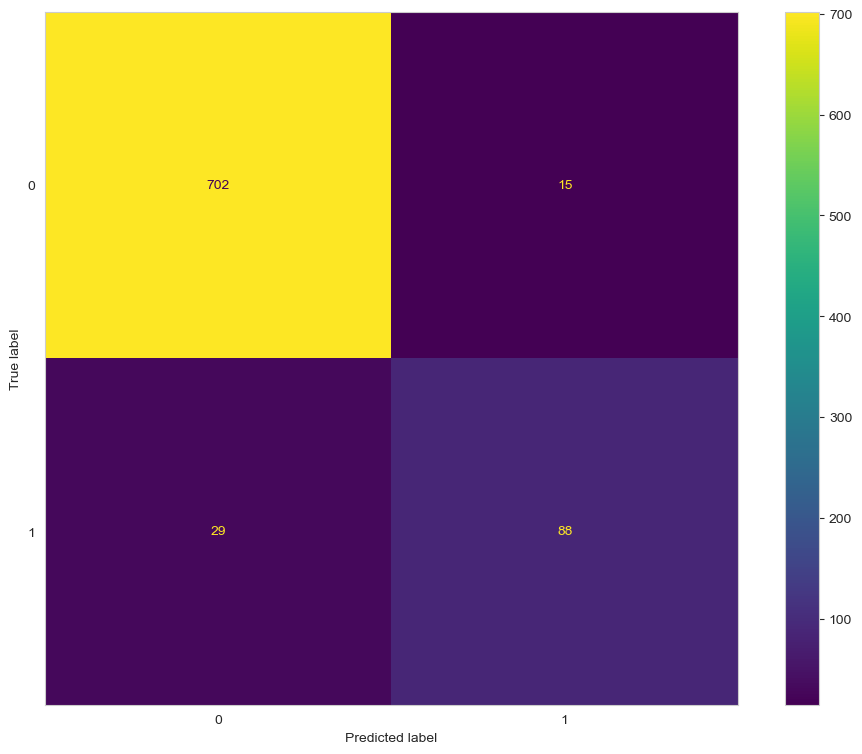

In [65]:
conf_matrix = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(conf_matrix).plot()
plt.grid(False);

**Модель xgboost.XGBClassifier оказалась несколько лучше**

### Задание 5. Рисуем

**дополнительно 0.5 балла**

Наверняка, в процессе выполнения этого задания вас переполняли какие-то эмоции. Нарисуйте что-то, что бы могло бы передать их (я сам не умею, так что, если это будет просто квадрат, тоже подойдет). Прикрепите сюда свой рисунок:

In [66]:
## PASTE YOUR MASTERPIECE HERE (/¯◡ ‿ ◡)/¯☆*##

![](../pictures/risunok_ml.png)

Мой ноут был недоволен взвалившимися на него вычислениями

### Therapy time

Напишите здесь ваши впечатления о задании (можно и не о задании): было ли интересно, было ли слишком легко или наоборот сложно и тд. Также сюда можно написать свои идеи по улучшению заданий, а также предложить данные, на основе которых вы бы хотели построить следующие дз.

**Ваши мысли:**